# STA 141B Final Project
## Data analysis on Restaurant Inspection 
### Winter, 2018
### By: Hemiao(Amy)Cui

#### Background: The primary goal of this project was to understand current restaurant inspection data through data munging and visualization. In addition to this, I seeked to understand whether the Yelp review may provide some hints for inspection results. 
#### Questions: Two major questions were asked:whether there is any temporal and spatial change of fail; whether the yelp review have any association with inspection result. 
#### Data Description: The initial restaurant file was obtained from Chicago data portal. It mainly includes data on restaurant name, inspection date, inspection type, violaton description, address and inspection result. 
#### Methodologies: Data visualization, API request, Geographical data analysis, Regular expression, Web scraping and NLTK.

In [1]:
import requests
import requests_cache
requests_cache.install_cache("mycache") 
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
import pandas as pd
import seaborn as sns
import numpy as np
import re
import requests_ftp 
import lxml
from bs4 import BeautifulSoup
import lxml.html as lx
import json
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import os
import string
import geopandas as gpd
import shapely.geometry as geom

### Cleaning

In [2]:
Restuarant_score=pd.read_csv('Food_Inspections.csv')
Restuarant_score=Restuarant_score.drop_duplicates()
Restuarant_only=Restuarant_score.loc[Restuarant_score['Facility Type']=='Restaurant',:] 
selected_restuarant=Restuarant_only[Restuarant_only['Results'].isin(['Pass','Pass w/ Conditions','Fail'])]
keep=['DBA Name','Risk','Address','Inspection Date','Inspection Type','Results','Violations','Latitude','Longitude']
selected_restuarant=selected_restuarant.loc[:,keep]
selected_restuarant=selected_restuarant.dropna()
selected_restuarant.isnull().sum()

DBA Name           0
Risk               0
Address            0
Inspection Date    0
Inspection Type    0
Results            0
Violations         0
Latitude           0
Longitude          0
dtype: int64

### Part I. API call to extract review on Yelp

In [3]:
def restaurant(name,lat,lon):
    """This function is to do restaurant api request on yelp and returns json files"""
    response2=requests.get("https://api.yelp.com/v3/businesses/search",params={
     'term':name,'latitude':lat,'longitude':lon},headers = {
     'Authorization': 'Bearer %s' % 'd-evYLs9_QoIuVcRHivjP_GdGBpV-GUwam7JRBhvdB7aVUlRCIsuZBXAqm3jo5v1Hm5Zf346bSTSd3KwXsCq95LD1pxJSCQGBHttPA0pSWvbQWKV596-uGXXkH-LWnYx'})
    return response2.json()['businesses']

In [4]:
def get_restaurant(row):
    """This function is to take in restauratant name and location and returns review information"""
    api_result=[]
    if 'INC' in row[0]: #need to exclude inc in restaurant because otherwises it would return wrong one; I figured it out after running several requests
        name=re.sub('\W+', ' ', row[0]).replace('INC','')
        temp=restaurant(name,row[7],row[8]) 
    else:
        name=re.sub('\W+', ' ', row[0])
        temp=restaurant(name,row[7],row[8])
    if temp: 
        yelpid=re.sub('\W+',' ',temp[0]['id'].encode('utf-8'))
        is_id_correct=name.lower().split()[0] in temp[0]['id'].encode('utf-8').lower() #to check whether the id is correct; This is not 100% accurate, but this is the best way that I can find;
        select=['rating','review_count','name','url','coordinates','categories','id']
        api_result_rating=temp[0]['rating']    
        api_result_review=temp[0]['review_count']
        api_result_url=temp[0]['url']
        api_result_cat=temp[0]['categories']
    else:
        is_id_correct='nan'
        api_result_rating='nan'    
        api_result_review='nan'
        api_result_url='nan'
        api_result_cat='nan'
    return is_id_correct,api_result_rating,api_result_review,api_result_url,api_result_cat

### Be careful! Below cell runs for 2hours!

In [ ]:
df=selected_restuarant
df['New']=df.apply(get_restaurant,axis=1)
df[['is_id_correct','api_result_rating', 'api_result_review','api_result_url','api_result_cat']]= df['New'].apply(pd.Series)
df=df.drop(['New'], axis=1)
df.to_csv('updated_restaurant_inspection.csv', encoding='utf-8')

### Part II. Are there temporal and spatical variations on inspection fail?

#### Question1. Does inspection fail ratio change over years? 

In [5]:
restaurant=pd.read_csv('updated_restaurant_inspection.csv')
restaurant["Fail"]=restaurant.Results.str.contains('Fail')*1
restaurant['Inspection Date'] = pd.to_datetime(restaurant['Inspection Date'])

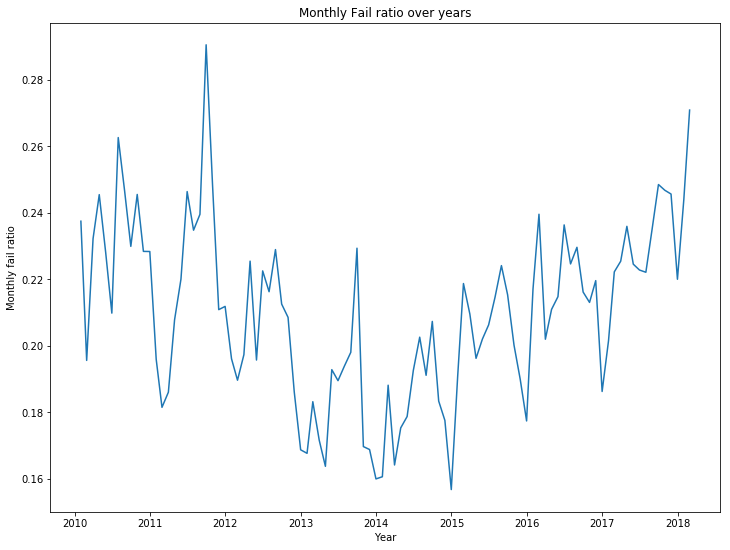

In [6]:
plt.rcParams['figure.figsize'] = (12, 9)
restaurant.index=restaurant["Inspection Date"]
ax=plt.plot(restaurant.groupby(pd.Grouper(freq='M')).Fail.mean())
plt.xlabel('Year')
plt.ylabel('Monthly fail ratio')
plt.title("Monthly Fail ratio over years",fontsize=12)
plt.show()

Monthly fail ratio decreased between 2013 to 2015, but went up again from 2015. 

#### Question2. Dos inspection fail ratio differ among different inspection types?

In [7]:
#below is select the majority types of inspection and combine some of similar types of inspections. 
toselect=['Canvass','Canvass Re-Inspection','Complaint','Complaint Re-Inspection','Complaint-Fire','Complaint-Fire Re-inspection',
          'Consultation','License','License Re-Inspection','License-Task Force','Short Form Complaint','Short Form Fire-Complaint','Suspected Food Poisoning',
          'Suspected Food Poisoning Re-inspection','Tag Removal','Task Force Liquor 1475']
selected=restaurant.loc[restaurant['Inspection Type'].isin(toselect),:]
selected.loc[:,'Inspection Type'].replace(['Complaint-Fire'],['Complaint'],inplace=True)
selected.loc[:,'Inspection Type'].replace(['Short Form Complaint'],['Complaint'],inplace=True)
selected.loc[:,'Inspection Type'].replace(['Short Form Fire-Complaint'],['Complaint'],inplace=True)
selected.loc[:,'Inspection Type'].replace(['Complaint-Fire Re-inspection'],['Complaint Re-Inspection'],inplace=True)

c:\python27\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Text(0.5,1,u'Fail ratio for different types of inspections')

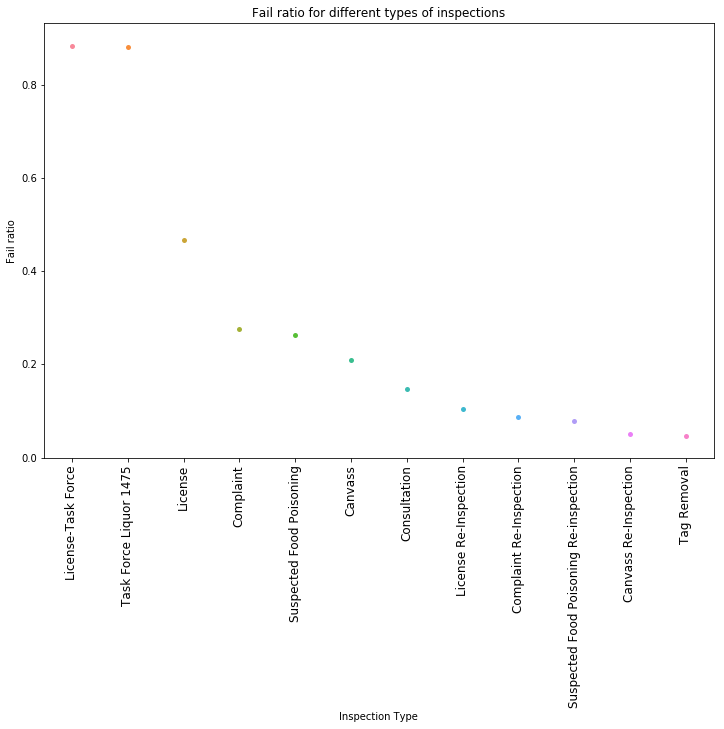

In [8]:
plt.rcParams['figure.figsize'] = (12, 8)
failrate=pd.crosstab(selected['Inspection Type'],selected['Results']).apply(lambda r: r/r.sum(), axis=1)
failrate=failrate.reset_index()
failrate_sort=failrate.sort_values(by="Fail",ascending=False)
ax=sns.stripplot(x=failrate_sort['Inspection Type'], y=failrate_sort["Fail"]) 
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize=12)
plt.ylabel('Fail ratio')
plt.title("Fail ratio for different types of inspections",fontsize=12)


License based inspection showed the highest fail ratio, indicating a large number of fails came from new restaurants.

#### Question3. Are there more restaurants licensed over years?

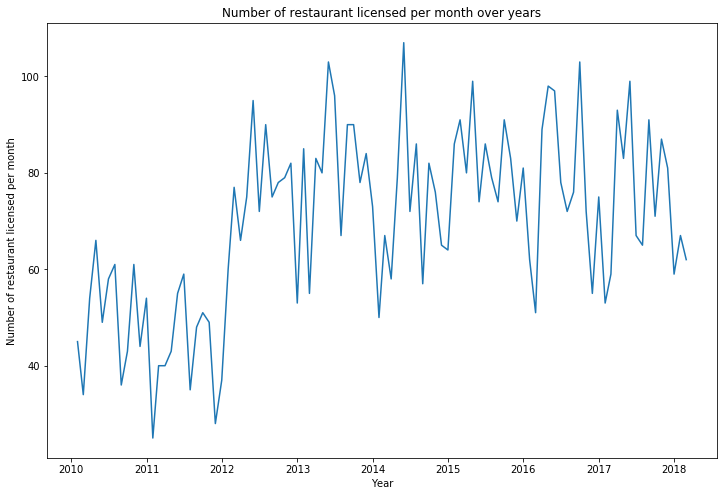

In [9]:
License=restaurant.loc[restaurant['Inspection Type']=='License',:]
plt.plot(License.groupby(pd.Grouper(freq='M')).size())
plt.xlabel('Year')
plt.ylabel('Number of restaurant licensed per month')
plt.title("Number of restaurant licensed per month over years",fontsize=12)
plt.show()

It is interesting to note that the number of new licensed restaurant significantly increased from the year 2012. 

#### Question4. Are there temporal changes of incidences of critical violations?

In [10]:
text_removed=restaurant["Violations"].str.findall('[0-9]{1,2}\.')
def getnumber(row):
    """This function to to extract violation number from violations column"""
    return np.array([s.strip('\.') for s in row],dtype='int64')
restaurant_violation_no=text_removed.apply(lambda x: getnumber(x))

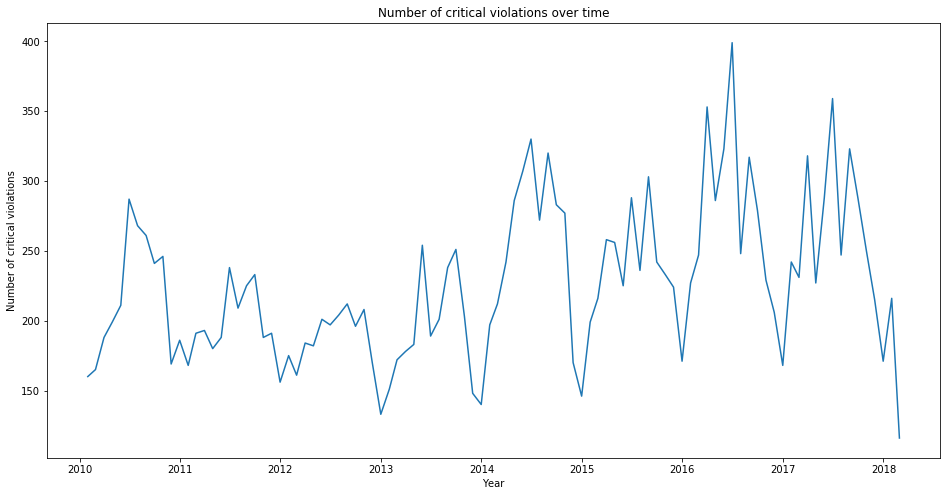

In [11]:
plt.rcParams['figure.figsize'] = (16, 8)
#below is to extract violotion number under 15, which refers to critical violations. 
critical_violation=[not set(range(15)).isdisjoint(item) for item in restaurant_violation_no] 
with_crit_violation=restaurant.loc[critical_violation,:]
plt.plot(with_crit_violation.groupby(pd.Grouper(freq='M')).size())
plt.xlabel('Year')
plt.ylabel('Number of critical violations')
plt.title("Number of critical violations over time",fontsize=12)
plt.show()

For all years, critical violations happened mostly near the summer time. The critical violation were lowest at the beginning and the end of a year.

#### Question5. Are there spatial variations of incidences of violations?

In [12]:
lnglat =[geom.Point(lng,lat) for lng, lat in zip(restaurant.Longitude,restaurant.Latitude)]
geo=gpd.GeoDataFrame(restaurant, geometry = lnglat, crs = {'init': 'epsg:4269'})
restaurant_geo=geo.loc[:,['Fail','geometry','DBA Name']]
Neighb=gpd.read_file('shapefiles\ZillowNeighborhoods-IL.shp')
Chicago_Neighb=Neighb.loc[Neighb['City']=='Chicago',:]
Chicago_Neighb=Chicago_Neighb.loc[:,['Name','geometry']]

In [13]:
joined=gpd.sjoin(restaurant_geo,Chicago_Neighb,how = "left",op = "within")
joined['Fail']=joined['Fail'].astype('int')

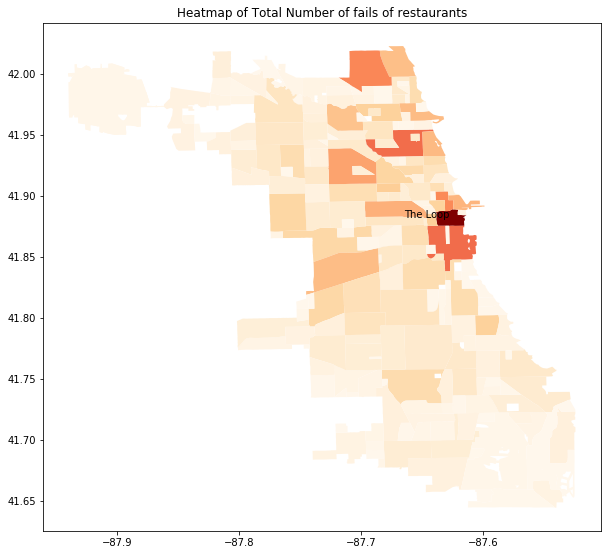

In [14]:
sumoffail=joined.groupby('Name')['Fail'].sum()
total=sumoffail.reset_index(name='total_fail')
merged=Chicago_Neighb.merge(total,on='Name')
ax=merged.plot(column = "total_fail", cmap = "OrRd", figsize = (10, 10))
total_fail_rank=merged.sort_values(by='total_fail',ascending=False)
coords = total_fail_rank.iloc[0,:].geometry.representative_point().coords[0]
ax.annotate(total_fail_rank.iloc[0,:].Name, xy = coords, horizontalalignment = "right")  
plt.title("Heatmap of Total Number of fails of restaurants",fontsize=12)
plt.show()

The downtown area(the Loop) has the highest number of fails. 

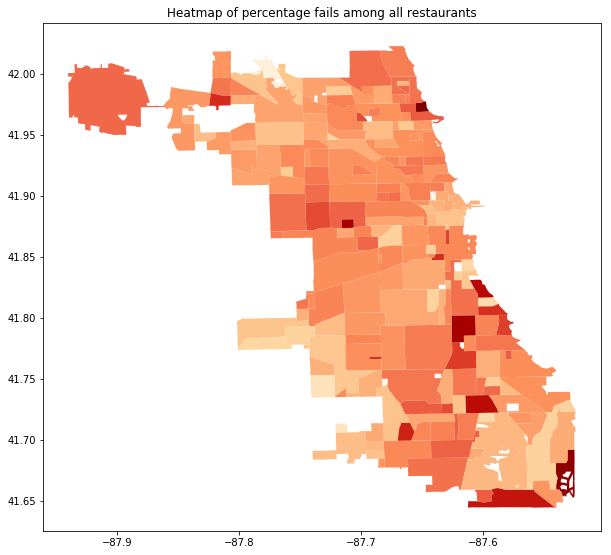

In [15]:
number_of_restaurant=joined.groupby('Name')['DBA Name'].count()
rate=sumoffail/number_of_restaurant
fail_rate=rate.reset_index(name='rate')
merged=Chicago_Neighb.merge(fail_rate,on='Name')
merged.plot(column = "rate", cmap = "OrRd", figsize = (10, 10))
plt.title("Heatmap of percentage fails among all restaurants",fontsize=12)
plt.show()

When I divided the number of fails by the total number of restaurant in each neighboorhood, I noticed that downtown had at almost the lowest fails. The South seems to have slightly more darker areas than North.Overall, there are not much segregation. But, there are some neighboorhoods that shower much higher fail ratio. 

### Part III. Is there any associaton between yelp review and inspection result?

#### Question6. Are fast food restaurants inspected more often?

#### Below is to first get rid of wrong yelp request, get failure ratio and total number of inspection over the 8 years for each restaurant since restaurants are inspected at least once. Some are inspected far more than others. Getting the fail ratio over history would give a more fair comparison. 

In [16]:
correct_review=restaurant.loc[restaurant['is_id_correct'].astype('str')=='True',:]
restfail=correct_review.groupby('DBA Name')['Fail'].sum().reset_index(name='number of fails')
size1=correct_review.groupby('DBA Name').size().reset_index(name='number of inspection')
size1['fail rate']=restfail['number of fails']/size1['number of inspection']
size1=size1.set_index('DBA Name')
first_for_each_DBA=correct_review.groupby('DBA Name').first()
combo=size1.join(first_for_each_DBA,how='left',rsuffix='r')
restaurant_with_fail_rate=combo.sort_values(by="fail rate",ascending=False)
restaurant_with_fail_rate['number of inspection'].describe()


count    6501.00000
mean        9.37948
std        30.03912
min         1.00000
25%         3.00000
50%         7.00000
75%        11.00000
max      1963.00000
Name: number of inspection, dtype: float64

In [18]:
def resultTitle(result_cat):
    """This function is to extract content from the category column"""
    titles=re.findall("\'.*?\'",re.sub('\'(title|alias)\'','',result_cat))
    titles=' '.join([re.sub('\'','',t).lower() for t in titles])
    return(titles)
restaurant_with_fail_rate['restaurant_types']=[resultTitle(r) for r in restaurant_with_fail_rate.api_result_cat.values]

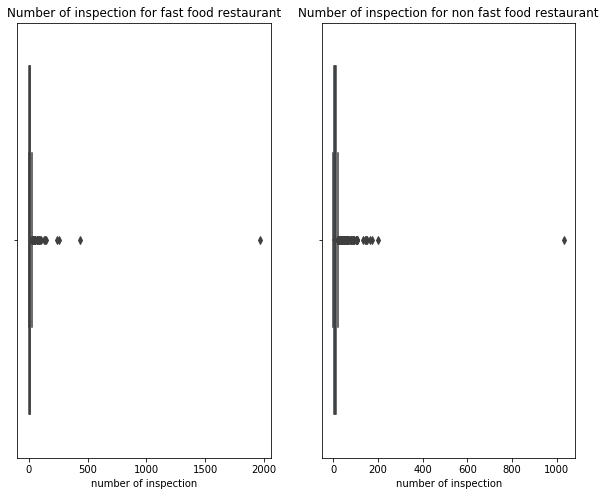

In [19]:
plt.rcParams['figure.figsize'] = (10, 8)
fastfood=restaurant_with_fail_rate.loc[restaurant_with_fail_rate.restaurant_types.str.contains('fast food'),:]
nonfastfood=restaurant_with_fail_rate.loc[~restaurant_with_fail_rate.restaurant_types.str.contains('fast food'),:]
f, axes = plt.subplots(1, 2)
sns.boxplot(fastfood['number of inspection'],ax=axes[0])
axes[0].title.set_text("Number of inspection for fast food restaurant")
sns.boxplot(nonfastfood['number of inspection'],ax=axes[1])
axes[1].title.set_text("Number of inspection for non fast food restaurant")
plt.show()

The restaurant that was most frequently inspected turned out to be fast food restaurant. But, the boxplot showed that other than those outliers, there was not much differences of inspection frequencies between fast food vs other types of restaurants. 

#### Question7. Do review number and review stars have any associations with inspection result? 

#### Below I look at restaurants have been inspected between 8 to 30 times since they represent restaurants that are established in 2010 (every restaurant should be inspected at least once per year). Also, because majority inspection number are under 30. 

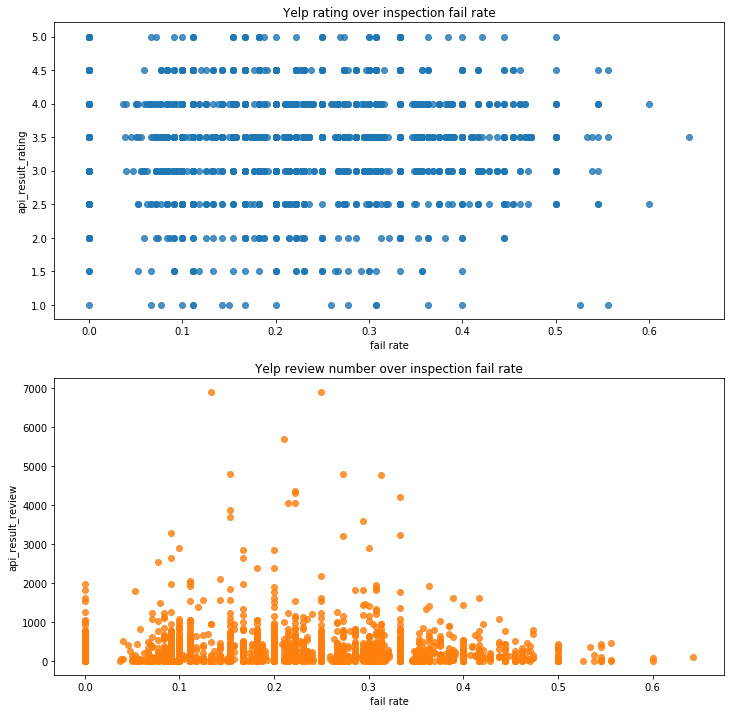

In [20]:
median=restaurant_with_fail_rate.loc[(restaurant_with_fail_rate['number of inspection']>8) & (restaurant_with_fail_rate['number of inspection']<30),:]
plt.rcParams['figure.figsize'] = (12, 12)
f, axes = plt.subplots(2, 1)
sns.regplot(median['fail rate'],median['api_result_rating'],ax=axes[0],fit_reg=False)
axes[0].title.set_text("Yelp rating over inspection fail rate")
sns.regplot(median['fail rate'],median['api_result_review'],ax=axes[1],fit_reg=False)
axes[1].title.set_text("Yelp review number over inspection fail rate")
plt.show()

Yelp rating does not seem to correlate with inspection result. Number of review provided slightly better idea of fail rate compared to yelp rating. For the restaurants rating of more than 1000, there are less likely to have fail ratio of more than 0.4.

#### Question7. Do review contents provide hints for restaurant inspection?¶

#### Below, I still look at restaurants that are inspected for between 8 to 30 times to gate off the effect of inspection times. For these restaurants, I compared the ones that high fail rate vs low fail rate to get an idea of whether the review content can provide some hints on inspection.  

In [21]:
High_fail=median.loc[median['fail rate']>=0.4,:]
Low_fail=median.loc[median['fail rate']<=0.05,:]

In [22]:
def get_review(url):
    """this function takes in an url and extact the all reviews from all pages on yelp"""
    url_list= [] 
    url_list.append(url)
    review_list=[]
    while len(url_list)!=0:
        response=requests.get(url_list.pop())
        html=response.text
        dbs = BeautifulSoup(html,'html.parser')  
        try: 
            reviews=[a.p.text for a in dbs.find_all('div','review-content')]
        except AttributeError:
            reviews=[a.text for a in dbs.find_all('div','review-content')]        
        try:
            nexturl=dbs.find_all('a','u-decoration-none next pagination-links_anchor')[0]['href'].encode('utf-8')
            url_list.append(nexturl) 
        except IndexError:
            url_list=[]       
        review_list.append(reviews)
    return review_list

 ### Be Careful! Below two cells runs for about 1 hour

In [34]:
Low_fail['api_result_url']=Low_fail['api_result_url'].map(lambda x:x.encode('utf-8')) 
Low_fail_review=Low_fail['api_result_url'].map(get_review)

c:\python27\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
High_fail['api_result_url']=High_fail['api_result_url'].map(lambda x:x.encode('utf-8'))
High_fail_review=High_fail['api_result_url'].map(get_review)

#### Below is to write review into folders. Here, review_folder_low_fail is to store reviews from low fail ratio restaurants; review_folder_high_fail is to store reviews from high fail ratio restaurants; 

In [ ]:
for i in range(len(Low_fail_review)):
    a=Low_fail_review.iloc[i]
    ajs=json.dumps(a)
    text_file = open("review_folder_low_fail/Output{}.txt".format(i), "w")
    text_file.write(ajs)
    text_file.close()

In [79]:
for i in range(len(High_fail_review)):
    a=High_fail_review.iloc[i]
    ajs=json.dumps(a)
    text_file = open("review_folder_high_fail/Output{}.txt".format(i), "w")
    text_file.write(ajs)
    text_file.close()

In [24]:
nltk.download('stopwords')
stemmer = PorterStemmer().stem 
tokenize = nltk.word_tokenize 
def stem(tokens,stemmer= PorterStemmer().stem):
    """This functon stems tokens"""
    return [stemmer(w.lower()) for w in tokens] 
def lemmatize(text): 
    """Extract simple lemmas based on tokenization and stemming"""
    return stem(tokenize(text))
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Hemiao
[nltk_data]     Cui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def review_dictionary(folder,files):
    """Returns a dictionary from lemmata to document ids containing that lemma"""
    textd = {} 
    for i in range(len(files)):
        reviewfile=open('{}/{}'.format(*tuple([folder,files[i]])), "r")
        review=reviewfile.read()
        s = set(lemmatize(review))- stop - set(string.punctuation)
        try:
            toks = toks | s 
        except NameError:
            toks = s   
        for tok in s:
            try:
                textd[tok].append(i)
            except KeyError:
                textd[tok] = [i]    
    return textd

In [26]:
def get_word_frequency(folder):
    """This function is to the take in a folder and get the word frequency for words in this folder"""
    allreview=os.listdir(folder)
    text_id=review_dictionary(folder,allreview)
    text_num = {key:len(set(val)) for key,val in text_id.items()}
    sorted_text = [(key, text_num[key]) for key in sorted(text_num, key=lambda x : text_num[x], reverse=True)]
    return pd.DataFrame(sorted_text)

In [27]:
pd_low_fail=get_word_frequency('review_folder_low_fail')
pd_high_fail=get_word_frequency('review_folder_high_fail')

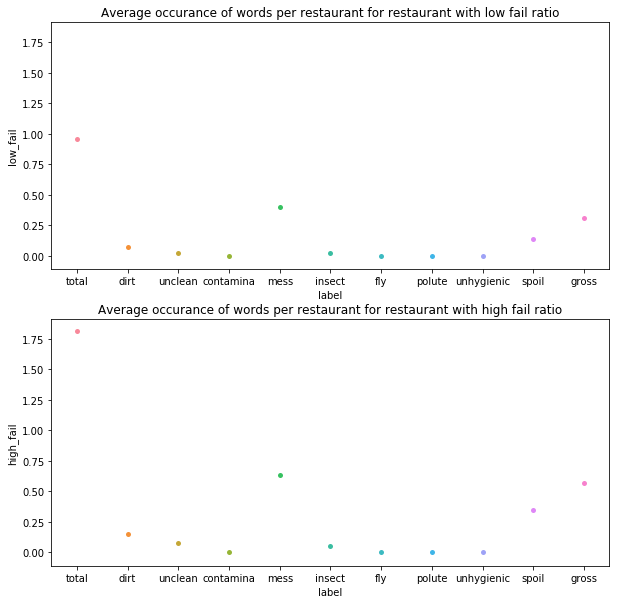

In [28]:
plt.rcParams['figure.figsize'] = (10, 10)
word_to_catch=['dirt','unclean','contamina','mess','insect','fly','polute','unhygienic','spoil','gross']
total_frequency_high_fail=float(pd_high_fail.loc[pd_high_fail[0].isin(word_to_catch),:][1].sum())/float(len(os.listdir("review_folder_high_fail")))
total_frequency_low_fail=float(pd_low_fail.loc[pd_low_fail[0].isin(word_to_catch),:][1].sum())/float(len(os.listdir("review_folder_low_fail")))
frequency=[total_frequency_high_fail,total_frequency_low_fail]
for item in word_to_catch:
    frequency_high_fail=float(pd_high_fail.loc[pd_high_fail[0].isin([item]),:][1].sum())/float(len(os.listdir("review_folder_high_fail")))
    frequency.append(frequency_high_fail)
    frequency_low_fail=float(pd_low_fail.loc[pd_low_fail[0].isin([item]),:][1].sum())/float(len(os.listdir("review_folder_low_fail")))    
    frequency.append(frequency_low_fail)
len(frequency)
frequency_df=pd.DataFrame(np.array(frequency).reshape(11,2))
frequency_df.columns=['high_fail','low_fail']
frequency_df['label']=['total']+word_to_catch
frequency_df
f, axes = plt.subplots(2, 1,sharey=True)
sns.stripplot(x=frequency_df['label'], y=frequency_df['low_fail'],ax=axes[0])
axes[0].title.set_text("Average occurance of words per restaurant for restaurant with low fail ratio")
sns.stripplot(x=frequency_df['label'], y=frequency_df['high_fail'],ax=axes[1])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize=12)
axes[1].title.set_text("Average occurance of words per restaurant for restaurant with high fail ratio")

Restaurant with high failure ratio (>0.4), there are more likely that you can some words related to dirty compared to restaurant with low failure ratio(<0.05). The frequent words that customers used to describe dirty are mess, spoil and gross. 

#### Challenges encountered during this project: 
#### 1. Yelp request returns wrong information when it cannot find a match. I had to check whether the result is correct after it is returned. But, it is tricky because the returned business id is not necessarily the restaurant name. 
#### 2.  I needed to scrape all pages of restaurant reviews, but I figured out how to do at the end. 
#### 3.  I explored many other questions such as whether such types of restaurant had higher fail ratio than others. But, many did not turn out to be interesting. 
#### Discussion:
#### 1. Some results are based on assumption and thus have their limiations. For example, using words related to dirty may be a bit subjective. Aspect based sentimental analysis would be done given more time. 
#### 2. The major finding of this study are:
##### a. New restaurants tended to have high fail than older; 
##### b. Critical violations happened far more likely in summer than in winter. 
##### c. Number of new restaurants increased significantly from 2012 than before. 
##### d. Some neighborhoods seems to have much higher fail ratio than others. Inspection officers should look at what's going on for those.
##### e. Yelp rating and number of review does not seem to have a clear association with inspection result. Review contents seems to provide more hints on the sanitation condition of a restaurant. 
